<font size="6">Архитектура Трансформер</font>

Рекуррентные сети для обработки последовательности имеют ряд недостатков:
- не способны запоминать дистантные зависимости,
- подвержены проблемам взрыва и затухания градиентов,
- выполняют вычисления последовательно, что занимает много времени.

В архитектуре sequence-to-sequence для более эффективного кодирования и декодирования последовательностей был добавлен механизм внимания, однако это не решает все существующие проблемы.

А что если отказаться от рекуррентности и использовать только механизм внимания?
Подобная архитектура получила название Трансформер.

[[paper] 🎓 Vaswani A. et al. (2017).Attention Is All You Need](https://arxiv.org/abs/1706.03762)

Как и в случае с рекуррентной сетью seq2seq, Трансформер состоит из блока кодировщика и блока декодировщика.
- Кодировщик обрабатывает исходную последовательность и кодирует ее.
- Декодировщик обрабатывает целевую последовательность с учетом информации из кодировщика. Выход из декодировщика является предсказанием модели.

Блок кодировщика состоит из 6 кодировщиков, расположенных друг за другом. Блок декодировщика – это стек декодировщиков, представленных в том же количестве.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/transformer.jpg" width="860"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Все кодировщики идентичны по структуре, хоть и имеют разные веса. Каждый можно разделить на два подслоя.
- Входная последовательность, поступающая в кодировщик, сначала проходит через слой внутреннего внимания (self-attention), помогающий кодировщику посмотреть на другие слова во входном предложении во время кодирования конкретного слова.
- Выход слоя внутреннего внимания отправляется в нейронную сеть прямого распространения (feed-forward neural network).

Декодировщик также содержит эти два слоя, но между ними есть слой внимания, который помогает декодировщику фокусироваться на релевантных частях исходного предложения (аналогично механизму внимания в моделях seq2seq).

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/enc_dec_tr.png" width="650"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Как и в случае других алгоритмов, каждое слово входной и целевой последовательности преобразуется в вектор.

После того как слова входного предложения преобразовались в эмбеддинги, каждый из них по отдельности проходит через слои кодировщика. Одна из основных особенностей Трансформера состоит в том, что каждое слово идет по своей собственной траектории.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/encoder.png" width="700"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Мы попробуем создать и обучить модель архитектуры Трансформер, основываясь на тьюториале:

[[doc] 🛠️ The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)

**Дисклеймер:** от вас не требуется полное понимание кода для создания и особенно обучения модели. Основная цель – показать, что обучить свой Трансформер не очень легко и очень долго, что объясняет необходимость в дальнейшем использовать предобученные модели.

# Создание модели

## Механизм внутреннего внимания

Пусть мы хотим перевести предложение: *The animal didn't cross the street because it was too tired*. Местоимение *it* может относиться к улице (*street*) или к животному (*animal*). Когда модель обрабатывает слово *it*, слой внутреннего внимания помогает понять, что *it* относится к *animal*.

По мере того как модель обрабатывает каждое слово входной последовательности, внутреннее внимание позволяет "взглянуть" на другие слова и лучше закодировать данное слово. Механизм внутреннего внимания – это метод, который Трансформер использует, чтобы смоделировать "понимание" других релевантных слов при обработке конкретного слова.

Во время кодирования *it* в кодировщике №5 часть механизма внимания фокусируется на *The animal* и использует фрагмент его представления для кодирования *it*.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/self_attention.png" width="400"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

### На примере векторов

При вычислении внутреннего внимания используются: вектор запроса $\text{query}$, вектор ключа $\text{key}$ и вектор значения $\text{value}$. Они создаются с помощью умножения эмбеддинга слова последовательности на три матрицы весов (линейных слоя) $W^Q, W^K, W^V$. Размер новых векторов – 64, размер исходных векторов – 512.

$q_i=x_iW^Q$

$k_i=x_iW^K$

$v_i=x_iW^V$

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/vector_attention.png" width="700"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Далее вычисляется коэффициент внутреннего внимания $\text{score}$ для $i$-го слова по отношению к каждому слову в предложении. Коэффициент определяет, насколько нужно сфокусироваться на других частях предложения во время кодирования слова в $i$-й позиции. Коэффициент подсчитывается с помощью скалярного произведения вектора запроса $q$ $i$-го слова и вектора ключа $k$ каждого слова.

$$\text{score}_{ij}=q_i \cdot k_j$$

На следующем шаге коэффициенты делятся на квадратный корень из $d_k$ – размера векторов ключа $k$. К получившимся значениям применяется функция активации softmax, чтобы коэффициенты в сумме давали 1. Полученный softmax-коэффициент определяет, в какой мере каждое из слов предложения "фокусируется" на другом слове.

$$\text{softmax.score}_{ij}=\text{softmax}(\dfrac{\text{score}_i}{\sqrt d_k})$$

После этого каждый вектор значения $v$ умножается на softmax-коэффициент, получаем взвешенные векторы. Идея в том, что нужно сохранять без изменений значения слов, на которых мы фокусируемся, и отвести на второй план нерелевантные слова (умножив их на небольшие значения, например, 0.001). Затем  взвешенные векторы складываются. Результат (взвешенная сумма) представляет собой выход слоя внутреннего внимания для $i$-го слова.

$$\text{sum}_i= \sum_{j=1}^n v_j \cdot \text{softmax.score}_{ij}$$

Полученный вектор передается дальше в нейронную сеть прямого распространения.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/attention_example.png" width="600"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

### На примере матриц

Аналогично, матрицы запроса $Q$, ключа $K$ и значения $V$ вычисляются с помощью умножения эмбеддингов матрицы $X$ на матрицы весов (линейные слои) $W^Q, W^K, W^V$. Каждая строка в матрице $X$ соответствует слову в предложении.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/matrix_attention.png" width="450"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Последующие этапы для вычисления выхода слоя внутреннего внимания могут быть отражены в одной формуле.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/attention_score.png" width="600"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Напишем функцию `attention` для подсчета внутреннего внимания.

$$\text{Attention}(Q, K, V) = \text{softmax}(\dfrac{QK^T}{\sqrt{d_k}})V$$

Для умножения матриц $Q, K, V$ используется метод `torch.matmul()`.

Транспонирование осуществляется с помощью метода `.transpose`.

In [ ]:
import math, torch

torch.manual_seed(42)


def attention(query, key, value, mask=None, dropout=None):
    """
    Compute 'Scaled Dot Product Attention'
    """
    d_k = query.size(-1)
    # compute the attention scores by using torch.matmul
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = torch.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    # compute the result as the values weighted by attention probabilities (again, using torch.matmul)
    result = torch.matmul(p_attn, value)
    return result

In [ ]:
import numpy as np

query = torch.tensor([[0, 0], [0, 1], [1, 1]], dtype=torch.float)
key = torch.tensor([[100, 0], [0, 100], [0, 0]], dtype=torch.float)
value = torch.tensor([[1, 0], [0, 1], [0, 0]], dtype=torch.float)
results = attention(query, key, value)
print(f"Query:\n{query}")
print(f"Key:\n{key}")
print(f"Value:\n{value}")
print(f"Results:\n{results}")

assert np.allclose(
    results[0].numpy(), [1 / 3, 1 / 3]
)  # the first query attends to all keys equally
assert np.allclose(
    results[1].numpy(), [0, 1]
)  # the second query attends only to the second key
assert np.allclose(
    results[2].numpy(), [1 / 2, 1 / 2]
)  # the third query attends to the first and second key equally

Query:
tensor([[0., 0.],
        [0., 1.],
        [1., 1.]])
Key:
tensor([[100.,   0.],
        [  0., 100.],
        [  0.,   0.]])
Value:
tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])
Results:
tensor([[3.3333e-01, 3.3333e-01],
        [1.9532e-31, 1.0000e+00],
        [5.0000e-01, 5.0000e-01]])


## Множественное внимание

В Трансформере механизм внутреннего внимания совершенствуется с помощью добавления множественного внимания (multi-headed attention). Это повышает способность модели фокусироваться на разных словах. В случае множественного внимания мы располагаем отдельными матрицами весов $W^Q, W^K, W^V$  для каждой "головы", что в результате дает разные матрицы $Q, K, V$. Как и ранее, матрица $X$ умножается на веса $W^Q, W^K, W^V$ для получения матриц $Q, K, V$.

Трансформер использует 8 "голов" внимания, так что в итоге у нас получается 8 наборов для каждого кодировщика и декодировщика. Сделав те же вычисления внутреннего внимания 8 раз с разными матрицами весов, в результате получим 8 разных матриц.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/multihead_attention.png" width="600"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Однако слой сети прямого распространения не ожидает, что к нему поступит 8 матриц — он ждет всего одну, в которую нам и необходимо сжать полученные матрицы. Чтобы это сделать, можно конкатенировать и затем умножить их на дополнительные веса матрицы $W^O$.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/concatenate.png" width="800"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Мы можем отобразить все "головы" внимания на одной картинке.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/multihead_viz.png" width="400"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Для создание множественного внимания необходим класс `MultiHeadedAttention`.

Каждая голова внимания независимо вычисляет внимание (скалярное произведение) для своих матриц $Q,K,V$. Следовательно, каждая голова может "обращать внимание" на разные части предложения.

$$\text{MultiHead}(Q, K, V) = \text{concat}(\text{head}_1, ..., \text{head}_h)W^O$$

In [ ]:
import copy


def clones(module, N):
    "Produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
import torch.nn as nn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch
        x = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Кодирование позиции

Из-за того, что мы избавились от рекуррентной нейронной сети, информация о порядке слов перестала учитываться моделью. В классе `MultiHeadedAttention` операции применяются к размерности 2 (признаки слов), но не к размерности 1 (слова последовательности).

Для того чтобы модель понимала порядок слов, вводятся векторы кодирования позиции (positional encoding). Они суммируются с векторами каждого слова.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/positional_encoding.png" width="850"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Информация о позиции кодируется с помощью тригонометрических функций: синуса и косинуса.

Пусть есть входная последовательность длины $L$, нужно закодировать позицию некоторого элемента $\text{pos}$.

$\text{pos}$ — индекс слова в исходной последовательности, $0 \leq \text{pos} < L$

$d$ — размер эмеддингов входного слоя

$i$ — номер координаты эмбеддинга входного слоя, $0 \leq i < \large \frac{d}{2}$

$p_0$ — первое слово последовательности, $d$ — длина вектора, $i$ — координаты вектора.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/pe1.png" width="500"></center>

<center><em>Source: <a href="https://www.youtube.com/watch?v=dichIcUZfOw">Visual Guide to Transformer Neural Networks</a></em></center>

Слова с разным номером позиции будут иметь разные значения значения на оси $y$. Однако для некоторых позиций ($p_0$ и $p_6$) значения совпадают, поскольку синус — периодическая функция.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/pe2.png" width="700"></center>

<center><em>Source: <a href="https://www.youtube.com/watch?v=dichIcUZfOw">Visual Guide to Transformer Neural Networks</a></em></center>

Получить разные значения можно благодаря параметру $i$. При изменении значения $i$ меняется частота, что приводит к получению разных значений для $p_0$ и $p_6$.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/pe3.png" width="800"></center>

<center><em>Source: <a href="https://www.youtube.com/watch?v=dichIcUZfOw">Visual Guide to Transformer Neural Networks</a></em></center>

Создадим класс `PositionalEncoding` для кодирования позиции.

$PE_{(\text{pos}, 2i)} = \sin(\dfrac{\text{pos}}{10000^{2i / d_\text{model}}})$

$PE_{(\text{pos}, 2i+1)} = \cos(\dfrac{\text{pos}}{10000^{2i / d_\text{model}}})$

In [ ]:
from torch.autograd import Variable


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = 10000 ** (torch.arange(0, d_model, 2) / d_model)
        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, : x.size(1)], requires_grad=False)
        return self.dropout(x)

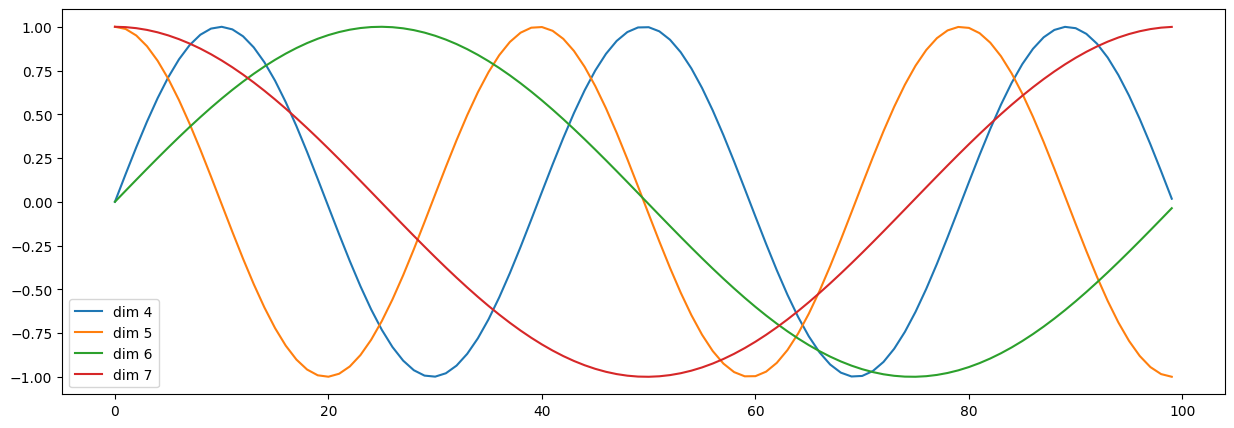

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
None

## Слои Embedding и преобразование Softmax

Аналогично другим моделям преобразования последовательностей, мы используем обученные эмбеддинги для преобразования входных и выходных токенов в векторы размерности $d_{\text{model}}$. Мы также используем линейное преобразование и функцию softmax для преобразования выходных данных декодировщика в прогнозируемые вероятности следующего токена. В нашей модели мы используем одну и ту же весовую матрицу между слоями эмбеддингов и линейным преобразованием, выполненным до softmax. В слоях эмбеддингов мы умножаем эти веса на $\sqrt{d_{\text{model}}}$.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Cеть прямого распространения

За слоем множественного внимания в кодировщике и декодировщике следует сеть прямого распространения. Она состоит из двух линейных слоев и функции активации ReLU между ними. Размер входных и выходных данных — 512, промежуточный размер — 2048 (в 4 раза больше).

In [ ]:
import torch.nn.functional as F


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Кодировщик

Можем перейти к реализации блока кодировщика. Он состоит из стека $N=6$ идентичных слоев.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/enc_details.png" width="400"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Каждый подслой (внутреннее внимание, полносвязный) включает сквозную связь (residual connection), за которой следует этап нормализации слоя ([layer normalization 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.htm)).



<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/connection_normalization.png" width="500"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Эмбеддинг каждого элемента последовательности дублируется: одна копия поступает на вход слоя (внимания или сети прямого распространения), другая копия не меняется и прибавляется к выходу слоя. Это позволяет избежать затухания градиента.

После применяется нормализация. Веса могут принимать значения в разном диапазоне, но скорость обучения одинаковая. Из-за этого возникает сложность с обновлением весов.

Нормализация применяется по предложениям: применяется к первому признаку каждого слова в первом предложении, затем ко второму признаку каждого слова в первом предожении и т.д.

Среднее: $\mu_i =\dfrac{1}{m}\sum\limits_{j=1}^mx_{ij}$

Стандартное отклонение: $\sigma_i = \dfrac{1}{m}\sum\limits_{j=1}^m(x_{ij}-\mu_i)$

Нормализованное значение: $\hat x_{ij} = \dfrac {x_{ij}-\mu_i}{\sigma_i}$

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-content/L05/out/layer_normalization.png" width="400"></center>

Мы используем сквозную связь вокруг каждого из двух подслоев, далее следует нормализация слоя.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        """
        Return a2 * x_normalized + b2,
        where x_normalized is calculated by subtracting row-wise means from x and dividing the result by row-wise standard deviation + eps.
        standard deviation is calculated with Bessel's correction (the default in Pytorch)
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
ln = LayerNorm(2, eps=0)
with torch.no_grad():
    result = ln(torch.tensor([[0.0, 1], [100, 101], [100, 200]])).numpy()

# becasue of Bessel's correction, standard deviation is pulled to 0. Here we un-pull it back.
print(f"Result of layer normalization:\n{result}")
result_unnormalized = result / np.sqrt(0.5)

Result of layer normalization:
[[-0.70710677  0.70710677]
 [-0.70710677  0.70710677]
 [-0.70710677  0.70710677]]


То есть результат каждого подслоя:
$$\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x)),$$

где $\mathrm{Sublayer}(x)$ — это функция, реализуемая самим подслоем.

Мы применяем `Dropout` к выходным данным каждого подслоя, прежде чем они складываются и нормализуются.

Чтобы упростить эти сквозные связи, все подслои в модели, а также слой эмбеддингов выдают выходные данные с размерностью $d_{\text{model}}=512$.

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Каждый слой состоит из двух подслоев. Первый представляет собой механизм множественного внимания, а второй — полносвязную сеть прямого распространения.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Декодировщик

Блок декодировщика устроен очень похоже, но есть несколько отличий.
- Декодировщик принимает два аргумента: целевое предложение и выход кодировщика.
- Используются два слоя множественного внимания:
  - маскированное множественное внимания для обработки целевого предложения,
  - множественное внимание между кодировщиком и декодировщиком для сравнения целевого и исходного предложений.
- Второй слой в качестве матриц $K$ и $V$ использует выход кодировщика.

Декодировщик выполняет задачу языкового моделирования и предсказывает вероятность следующего слова. Следовательно, при обработке целевой последовательности он не может "заглядывать" вперед и анализировать контекст, который еще не был сгенерирован. Поэтому используется маскирование всех позиций после текущей, их векторы заполняются значениями `-inf`.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/enc_dec_details.png" width="800"></center>

<center><em>Source: <a href="https://jalammar.github.io/illustrated-transformer/">The Illustrated Transformer</a></em></center>

Декодировщик также состоит из стека из $N=6$ идентичных слоев.

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

В дополнение к двум подслоям на каждом слое кодировщика, декодировщик содержит третий подслой, который применяет механизм множественного внимания к выходным данным кодировщика. Как и в случае с кодировщиком, мы используем сквозную связь вокруг каждого из подслоев с последующей нормализацией слоя.

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

Мы также модифицируем подслой внутреннего внимания в стеке декодировщика, добавляя маскирование. Это необходимо, чтобы не учитывать токены в следующих позициях при анализе текущей и предыдущей позиций. Маскирование гарантирует, что предсказания для позиции $i$ могут зависеть только от выходных данных на позициях, меньших, чем $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype("uint8")
    return torch.from_numpy(subsequent_mask) == 0

Маска внимания показывает позицию (строка), на которую разрешено смотреть каждому слову (столбец). Слова блокируются для того, чтобы во время обучения можно было обратить внимание на будущие слова.

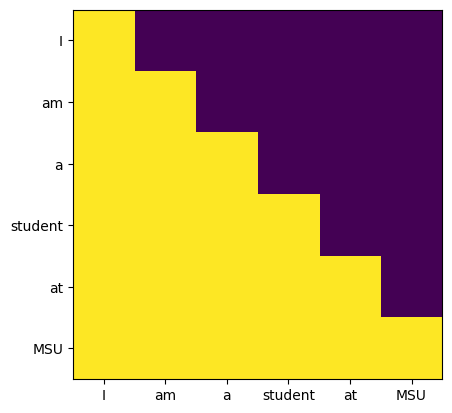

In [ ]:
ax = plt.gca()
data = subsequent_mask(6)[0]
ax.imshow(data)

ticks = [0, 1, 2, 3, 4, 5]
ticklabels = ["I", "am", "a", "student", "at", "MSU"]
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)

plt.show()

## Трансформер

Определим функцию от гиперпараметров для построения полной модели.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/transformer_full.png" width="1000"></center>

<center><em>Source: <a href="https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html">Sequence to Sequence and Attention</a></em></center>

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    Base for this and many other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model from hyperparameters"
    c = copy.deepcopy  # use it for attn, ffn, and position in the model layers
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    # insert correct arguments into the EncoderDecoder constructor.
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

Посчитаем количество параметров модели:

In [ ]:
# Small example model.
tmp_model = make_model(10, 30, 2)
(
    sum(p.numel() for p in tmp_model.encoder.parameters())
    + sum(p.numel() for p in tmp_model.decoder.parameters())
    + sum(p.numel() for p in tmp_model.tgt_embed.parameters())
    + sum(p.numel() for p in tmp_model.src_embed.parameters())
    + sum(p.numel() for p in tmp_model.generator.parameters())
)

14750750

# Обучение модели

В этом разделе описывается режим обучения для нашей модели. Часть функций мы не будем разбирать подробно и импортируем их из файла.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/transformer_code.py

## Деление на батчи и маскирование

Вначале определим формат батча, который содержит исходное и целевое предложения для обучения, а также создание масок.

In [ ]:
class Batch:
    "Object for holding a batch of data with mask during training."

    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        )
        return tgt_mask

## Цикл обучения

Затем создадим функцию для обучения, подсчета значения функции потерь и обновления параметров.

In [ ]:
import time


def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print(
                "Epoch Step: %d Loss: %f Tokens per Sec: %f"
                % (i, loss / batch.ntokens, tokens / elapsed)
            )
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Оптимизатор

Будем использовать оптимизатор `Adam` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) с параметрами $\beta_1=0.9$, $\beta_2=0.98$ и $\epsilon=10^{-9}$.  Скорость обучения будет варьироваться в соответствии с формулой:
$$
\text{lrate} = d_{\text{model}}^{-0.5} \cdot
  \min(\text{step_num}^{-0.5},
    \text{step_num} \cdot \text{warmup_steps}^{-1.5})
$$

Это соответствует линейному увеличению скорости обучения на первых этапах $\text{warmup_steps}$ и последующему ее уменьшению пропорционально обратному квадратному корню из номера шага. Будем использовать значение $\text{warmup_steps}=4000$.

Импортируем нужный класс из файла и построим пример графиков для различных размеров модели и гиперпараметров оптимизации.

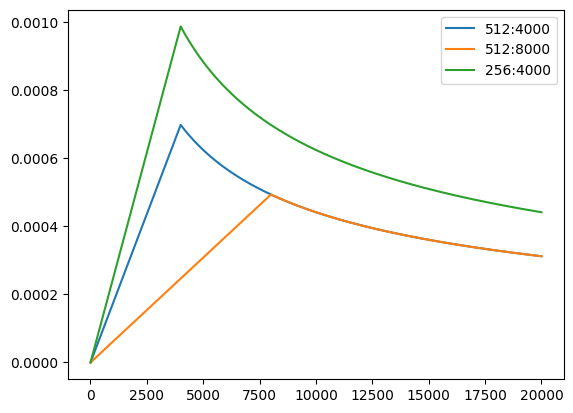

In [ ]:
import matplotlib.pyplot as plt
from transformer_code import NoamOpt

%matplotlib inline

# Three settings of the lrate hyperparameters.
opts = [
    NoamOpt(512, 1, 4000, None),
    NoamOpt(512, 1, 8000, None),
    NoamOpt(256, 1, 4000, None),
]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## Регуляризация

Сглаживание меток (label smoothing) — это метод, используемый для регуляризации процесса обучения нейронной сети. Он помогает избежать переобучения за счет уменьшения зависимости модели от правильных меток во время процесса обучения. Это работает за счет повышения уверенности модели в «неправильных» ярлыках.

Во время обучения будем использовать сглаживание значений меток с параметром $\large \varepsilon_{ls}$ $=0.1$. Вместо one-hot распределения по одной целевой группе мы создаем распределение, в котором наибольшую вероятность имеет правильное слово, а остальные значения вероятности распределяются по всему словарю.

\begin{align*}
q_i =
\left\{
    \begin {aligned}
         & 1 - \varepsilon \quad & \text{if } i=y, \\
         & \varepsilon/(K-1) \quad & \text{otherwise}                  
    \end{aligned}
\right.
\end{align*}

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/label_smoothing.png" width="700"></center>

<center><em>Source: <a href="https://arxiv.org/abs/2011.12562">Delving Deep into Label Smoothing</a></em></center>

# Пример на искусственных данных

Попробуем применить модель для выполнения простой задачи копирования. Задан случайный набор входных символов из небольшого словаря. Цель состоит в том, чтобы сгенерировать те же символы.

Чтобы дальнейший код воспроизводился, зафиксируем случайные состояния:

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)


set_random_seed(42)

Напишем функцию для генерации данных.

In [ ]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

Определим функцию потерь.

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = (
            self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))
            / norm
        )
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

Запустим обучение.

In [ ]:
from transformer_code import LabelSmoothing

# Train the simple copy task
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(
    model.src_embed[0].d_model,
    1,
    400,
    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9),
)

for epoch in range(5):
    model.train()
    run_epoch(
        data_gen(V, 20, 30),
        model,
        SimpleLossCompute(model.generator, criterion, model_opt),
    )
    model.eval()
    print(
        run_epoch(
            data_gen(V, 20, 5),
            model,
            SimpleLossCompute(model.generator, criterion, None),
        )
    )

Epoch Step: 1 Loss: 3.097661 Tokens per Sec: 439.423828
Epoch Step: 1 Loss: 1.848220 Tokens per Sec: 568.307800
tensor(1.7802)
Epoch Step: 1 Loss: 1.906642 Tokens per Sec: 587.066650
Epoch Step: 1 Loss: 1.513934 Tokens per Sec: 785.652100
tensor(1.4600)
Epoch Step: 1 Loss: 2.058664 Tokens per Sec: 478.329498
Epoch Step: 1 Loss: 1.019274 Tokens per Sec: 798.913757
tensor(1.0674)
Epoch Step: 1 Loss: 1.301459 Tokens per Sec: 607.027771
Epoch Step: 1 Loss: 0.787863 Tokens per Sec: 833.029114
tensor(0.7463)
Epoch Step: 1 Loss: 1.556463 Tokens per Sec: 617.839661
Epoch Step: 1 Loss: 0.586133 Tokens per Sec: 839.070129
tensor(0.5792)


Применим модель и декодируем её предсказания.

In [ ]:
def decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory,
            src_mask,
            Variable(ys),
            Variable(subsequent_mask(ys.size(1)).type_as(src.data)),
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys


model.eval()
src = Variable(torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]))
print(f"Input:\n{src}")
src_mask = Variable(torch.ones(1, 1, 10))
print(f"Output:\n{decode(model, src, src_mask, max_len=10, start_symbol=1)}")

Input:
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
Output:
tensor([[1, 2, 3, 4, 3, 5, 6, 8, 9, 9]])


# Пример на реальных данных

Теперь мы рассмотрим реальный пример с использованием русско-английских параллельных данных проекта [Tatoeba 🛠️[doc]](https://tatoeba.org/ru). Эта задача намного меньше, чем рассмотренная в исходной статье, но она иллюстрирует всю систему в целом.

## Подготовка данных

Воспользуемся библиотекой [spaCy 🛠️[doc]](https://spacy.io/) для токенизации.

In [ ]:
from IPython.display import clear_output

!python -m spacy download en_core_web_sm -q
!python -m spacy download ru_core_news_sm -q
!pip install -q datasets==3.6.0

clear_output()

In [ ]:
import spacy

spacy_ru = spacy.load("ru_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")


def tokenize_ru(text):
    return [tok.text for tok in spacy_ru.tokenizer(text)]


def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


BOS_WORD = "<s>"
EOS_WORD = "</s>"
BLANK_WORD = "<blank>"
UNK_WORD = "<unk>"

MAX_LEN = 100

Загрузим данные проекта [Tatoeba 🛠️[doc]](https://huggingface.co/datasets/tatoeba) из раздела [Datasets 🛠️[doc]](https://huggingface.co/datasets) сайта HuggingFace. С этим полезным ресурсом для работы с Трансформерными моделями мы познакомимся подробнее на следующих занятиях.

Датасет Tatoeba — это набор из пар предложений на русском языке. Загрузим примеры на английском и русском языках, указав соответствующие значения для `lang1` и `lang2`. Для загрузки набора данных используется метод `load_dataset`.

In [ ]:
from datasets import load_dataset

data = load_dataset("tatoeba", lang1="en", lang2="ru", trust_remote_code=True)
clear_output()

Набор данных является объектом класса `DatasetDict`. Он имеет ключи и значения.

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 523656
    })
})

Конкретный объект датасета можно получить по индексу.

In [ ]:
data["train"][0]

{'id': '0',
 'translation': {'en': "For once in my life I'm doing a good deed... And it is useless.",
  'ru': 'Один раз в жизни я делаю хорошее дело... И оно бесполезно.'}}

Удалим примеры длинее 100 токенов и разделим данные на обучающую и тестовую выборки.

In [ ]:
data2 = (
    data["train"]
    .filter(
        lambda x: max(len(x["translation"]["ru"]), len(x["translation"]["en"]))
        <= MAX_LEN
    )
    .train_test_split(test_size=1000, shuffle=True, seed=2)
)
data2

Filter:   0%|          | 0/523656 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 519480
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 1000
    })
})

Будем решать задачу перевода с русского на английский язык.

Запишем в отдельные переменные предложения на исходном языке (source) и на целевом языке (target).

In [ ]:
train_src = [d["ru"] for d in data2["train"]["translation"]]
train_trg = [d["en"] for d in data2["train"]["translation"]]

val_src = [d["ru"] for d in data2["test"]["translation"]]
val_trg = [d["en"] for d in data2["test"]["translation"]]

In [ ]:
print(f"Number of source sentences in train set: {len(train_src)} ")
print(f"Number of target sentences in train set: {len(train_trg)} ")
print(f"Example of source sentence in train set:\n'{train_src[0]}'")
print(f"Example of target sentence in train set:\n'{train_trg[0]}'\n")
print(f"Number of source sentences in test set: {len(val_src)} ")
print(f"Number of target sentences in test set: {len(val_trg)} ")
print(f"Example of source sentence in test set:\n'{val_src[0]}'")
print(f"Example of target sentence in test set:\n'{val_trg[0]}'\n")

Number of source sentences in train set: 519480 
Number of target sentences in train set: 519480 
Example of source sentence in train set:
'Слишком быстрая езда опасна.'
Example of target sentence in train set:
'Driving too fast is dangerous.'

Number of source sentences in test set: 1000 
Number of target sentences in test set: 1000 
Example of source sentence in test set:
'Не беспокойтесь. Мы её найдём.'
Example of target sentence in test set:
'Don't worry. We'll find her.'



Напишем функцию для создания словаря токенов исходного и целевого языков.

In [ ]:
from collections import Counter
from tqdm.auto import tqdm


def build_vocab(
    texts,
    tokenize,
    min_freq=3,
    init_token=BOS_WORD,
    eos_token=EOS_WORD,
    pad_token=BLANK_WORD,
    unk_token=UNK_WORD,
):
    cnt = Counter()
    for text in tqdm(texts):
        cnt.update(tokenize(text))
    vocab = [pad_token, init_token, eos_token, unk_token]
    for w, c in cnt.most_common():
        if c < min_freq:
            break
        vocab.append(w)
    return vocab


src_vocab = build_vocab(train_src, tokenize_ru)
tgt_vocab = build_vocab(train_trg, tokenize_en)

  0%|          | 0/519480 [00:00<?, ?it/s]

  0%|          | 0/519480 [00:00<?, ?it/s]

In [ ]:
print(f"Size of source language vocabulary: {len(src_vocab)}")
print(f"First 50 tokens in source language vocabulary:\n{src_vocab[:50]}\n")
print(f"Size of target language vocabulary: {len(tgt_vocab)}")
print(f"First 50 tokens in target language vocabulary:\n{tgt_vocab[:50]}")

Size of source language vocabulary: 35289
First 50 tokens in source language vocabulary:
['<blank>', '<s>', '</s>', '<unk>', '.', ',', 'не', 'Я', '?', 'Том', 'что', 'в', 'это', 'на', '-', 'с', 'я', 'Ты', 'Мэри', 'ты', 'мне', 'Он', 'Вы', 'меня', 'Тома', 'и', 'У', 'Это', 'Мы', 'вы', 'бы', 'Она', 'Не', 'Тому', 'сказал', 'его', 'чтобы', 'был', 'у', 'как', '!', 'то', 'очень', 'Мне', 'тебя', 'тебе', 'он', 'за', 'по', 'так']

Size of target language vocabulary: 14772
First 50 tokens in target language vocabulary:
['<blank>', '<s>', '</s>', '<unk>', '.', 'I', 'Tom', 'to', 'you', '?', "n't", 'the', 'a', 'is', 'do', 'that', "'s", 'me', 'was', 'in', ',', 'of', 'You', 'did', 'it', 'have', 'Mary', 'know', 'for', 'He', "'m", 'Do', 'We', 'The', 'this', 'not', 'want', 'her', 'with', 'are', 'be', 'he', 'your', 'and', 'my', 'him', 'on', 'like', 'It', 'his']


Создадим словарь соответствия токенов и индексов для исходного и целевого языков.

In [ ]:
inv_voc_src = {w: i for i, w in enumerate(src_vocab)}
inv_voc_tgt = {w: i for i, w in enumerate(tgt_vocab)}

print(f"Mapping word2id dictionary for source language: {inv_voc_src}")
print(f"Mapping word2id dictionary for target language: {inv_voc_tgt}")

Mapping word2id dictionary for source language: {'<blank>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '.': 4, ',': 5, 'не': 6, 'Я': 7, '?': 8, 'Том': 9, 'что': 10, 'в': 11, 'это': 12, 'на': 13, '-': 14, 'с': 15, 'я': 16, 'Ты': 17, 'Мэри': 18, 'ты': 19, 'мне': 20, 'Он': 21, 'Вы': 22, 'меня': 23, 'Тома': 24, 'и': 25, 'У': 26, 'Это': 27, 'Мы': 28, 'вы': 29, 'бы': 30, 'Она': 31, 'Не': 32, 'Тому': 33, 'сказал': 34, 'его': 35, 'чтобы': 36, 'был': 37, 'у': 38, 'как': 39, '!': 40, 'то': 41, 'очень': 42, 'Мне': 43, 'тебя': 44, 'тебе': 45, 'он': 46, 'за': 47, 'по': 48, 'так': 49, 'было': 50, 'знаю': 51, 'хочу': 52, 'есть': 53, 'её': 54, 'всё': 55, 'ещё': 56, 'из': 57, 'о': 58, 'Что': 59, '"': 60, 'сделать': 61, 'Почему': 62, 'Они': 63, 'вам': 64, 'вас': 65, 'ему': 66, 'здесь': 67, 'знал': 68, 'могу': 69, 'В': 70, 'этого': 71, 'хотел': 72, 'мы': 73, 'нужно': 74, 'будет': 75, 'никогда': 76, 'Как': 77, 'когда': 78, 'больше': 79, 'Томом': 80, 'думаю': 81, 'нас': 82, 'надо': 83, 'нибудь': 84, 'уже': 85, 'н

Токенизируем предложения, заменив токены на индексы в соответствии с нужным словарем.

In [ ]:
def tokenize(text, tokenize_fn, inv_vocab, bos_id=1, eos_id=2, unk_id=3):
    result = [bos_id]
    for word in tokenize_fn(text):
        if word in inv_vocab:
            result.append(inv_vocab[word])
        else:
            result.append(unk_id)
    result.append(eos_id)
    return result


train_src_tokenized = [tokenize(t, tokenize_ru, inv_voc_src) for t in tqdm(train_src)]
train_tgt_tokenized = [tokenize(t, tokenize_en, inv_voc_tgt) for t in tqdm(train_trg)]

val_src_tokenized = [tokenize(t, tokenize_ru, inv_voc_src) for t in tqdm(val_src)]
val_tgt_tokenized = [tokenize(t, tokenize_en, inv_voc_tgt) for t in tqdm(val_trg)]

  0%|          | 0/519480 [00:00<?, ?it/s]

  0%|          | 0/519480 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
print(
    f"First sentence in source language train set after tokenization:\n{train_src_tokenized[0]}"
)
print(
    f"First sentence in target language train set after tokenization:\n{train_tgt_tokenized[0]}"
)

First sentence in source language train set after tokenization:
[1, 2694, 7226, 28600, 7007, 4, 2]
First sentence in target language train set after tokenization:
[1, 6791, 120, 550, 13, 758, 4, 2]


Определим функцию для выравнивания длины последовательностей путём дополнения:

In [ ]:
def padding(sequences, pad_id=0):
    max_len = max(len(s) for s in sequences)
    return [s + [pad_id] * (max_len - len(s)) for s in sequences]

In [ ]:
print(
    f"Example sentences in source language train set after tokenization:\n\
{padding(train_src_tokenized[0:3])}"
)

Example sentences in source language train set after tokenization:
[[1, 2694, 7226, 28600, 7007, 4, 2, 0], [1, 9, 3975, 18, 1214, 4, 2, 0], [1, 31, 21343, 25, 2062, 169, 4, 2]]


Немного поменяем структуру батча и функцию для маскирования.

In [ ]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens


def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

Определим функцию для рандомизации данных при обучении.

In [ ]:
import random
from tqdm.auto import trange


def data_iterator(srcs, tgts, batch_size=128, shuffle=True):
    if shuffle:
        pairs = list(zip(srcs, tgts))
        random.shuffle(pairs)
        srcs, tgts = [list(t) for t in zip(*pairs)]

    for i in trange(0, len(srcs), batch_size):
        x = torch.tensor(padding(srcs[i : i + batch_size]))
        y = torch.tensor(padding(tgts[i : i + batch_size]))
        src = Variable(x, requires_grad=False)
        tgt = Variable(y, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

## Обучение

Проверим, доступен ли нам ускоритель `torch.cuda` [🛠️[doc]](https://pytorch.org/docs/stable/notes/cuda.html).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


Создадим модель с архитектурой Трансформер и выведем ее структуру.

In [ ]:
from transformer_code import get_std_opt

# Create the model an load it onto our GPU
pad_idx = tgt_vocab.index("<blank>")
model = make_model(len(src_vocab), len(tgt_vocab), N=6)
model_opt = get_std_opt(model)
model.to(device)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

Посчитаем количество параметров модели:

In [ ]:
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 77,349,812 trainable parameters


Установим размер батча и определим функцию потерь.

In [ ]:
BATCH_SIZE = 128
criterion = LabelSmoothing(size=len(tgt_vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()

LabelSmoothing(
  (criterion): KLDivLoss()
)

Чтобы обучить нашу довольно большую модель, определим функцию для подсчета ошибки, которая будет использоваться для оптимизации обучения.

In [ ]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.item()  # .data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

Определим функции для обучения и валидации.

In [ ]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = (
            batch.src.to(device),
            batch.trg.to(device),
            batch.src_mask.to(device),
            batch.trg_mask.to(device),
        )
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens)

        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)


def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.eval()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = (
            batch.src.to(device),
            batch.trg.to(device),
            batch.src_mask.to(device),
            batch.trg_mask.to(device),
        )
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens)

Обучение модели занимает около часа. Его можно осуществить следующим образом:

```python
for epoch in trange(3):
    train_epoch(data_iterator(train_src_tokenized, train_tgt_tokenized, batch_size=BATCH_SIZE), model, criterion, model_opt)
    valid_epoch(data_iterator(val_src_tokenized, val_tgt_tokenized, batch_size=BATCH_SIZE), model, criterion)

torch.save(model.state_dict(), "model_weights.pth")
```

В целях экономии времени и ресурсов загрузим веса предварительно обученной модели.

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/datasets/ru_en_model.zip -P /content/weights
!unzip -q /content/weights/ru_en_model.zip -d ./weights

In [ ]:
model = make_model(len(src_vocab), len(tgt_vocab), N=6)
model.load_state_dict(torch.load("weights/model_weights.pth"))
model.to(device)
print(model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

## Тестирование и оценка

Применим модель к произвольному предложению.

In [ ]:
model.eval()
sent = "Вы можете перевести это предложение?"
src = Variable(torch.LongTensor([tokenize(sent, tokenize_ru, inv_voc_src)]))
src_mask = (src != src_vocab.index("<blank>")).unsqueeze(-2)
print(f"Tokenized source sentence:\n{src}")
print(f"Mask for tokenized source sentence:\n{src_mask}")

Tokenized source sentence:
tensor([[   1,   22,  203, 1738,   12,  431,    8,    2]])
Mask for tokenized source sentence:
tensor([[[True, True, True, True, True, True, True, True]]])


In [ ]:
out = decode(
    model,
    src.to(device),
    src_mask.to(device),
    max_len=60,
    start_symbol=tgt_vocab.index("<s>"),
)
print(f"Tokenized translated sentence:\n{out}")

Tokenized translated sentence:
tensor([[  1, 136,   8, 995,  34, 660,   9,   2,   9,   2,   9,   2,   9,   2,
           9,   2,   9,   2,   9,   2,   9,   2,   9,   2,   9,   2,   9,   2,
           9,   2,   9,   2,   9,   2,   9,   2,   9,   2,   9,   2,   9,   2,
           9,   2,   9,   2,   9,   2,   9,   2,   9,   2,   9,   2,   9,   2,
           9,   2,   9,   2]], device='cuda:0')


In [ ]:
subword_punctuation = [",", ".", "!", "?", "n't", "'s", "'ve", "'re", "'m", "'d", "'ll"]
trans = ""
for i in range(1, out.size(1)):
    sym = tgt_vocab[out[0, i]]
    if sym == "</s>":
        break
    if i != 1 and sym not in subword_punctuation:
        trans += " "
    trans += sym
print(f"Translation: {trans}")

Translation: Can you translate this sentence?


Чтобы оценить качество модели, нужно записать предсказания модели для всех предложений валидационной выборки.

Попробуем сделать это для 20 первых предложений.

In [ ]:
def inference(source_sentences, subword_punctuation):
    model.eval()
    predictions = []
    for sentence in source_sentences:
        src = torch.LongTensor(sentence).unsqueeze(0)
        src_mask = (src != src_vocab.index("<blank>")).unsqueeze(-2)
        out = decode(
            model,
            src.to(device),
            src_mask.to(device),
            max_len=60,
            start_symbol=tgt_vocab.index("<s>"),
        )
        trans = ""
        for i in range(1, out.size(1)):
            sym = tgt_vocab[out[0, i]]
            if sym == "</s>":
                break
            if i != 1 and sym not in subword_punctuation:
                trans += " "
            trans += sym
        predictions.append(trans)
    return predictions

In [ ]:
predictions = inference(val_src_tokenized[:20], subword_punctuation)
for i in range(20):
    print(f"Source sentence: {val_src[i]}")
    print(f"Translation: {predictions[i]}")
    print(f"Target sentence: {val_trg[i]}")
    print()

Source sentence: Не беспокойтесь. Мы её найдём.
Translation: Don't worry about her.
Target sentence: Don't worry. We'll find her.

Source sentence: Том сказал Мэри, что у неё нет выбора.
Translation: Tom said that Mary had a choice.
Target sentence: Tom told Mary she had no choice.

Source sentence: Я не думаю, что эти чернильные пятна можно вывести.
Translation: I don't think that it's broken.
Target sentence: I don't think these ink stains will come off.

Source sentence: Как вы думаете, что мне купить?
Translation: How do you think I should buy?
Target sentence: What do you think I should buy?

Source sentence: Давай доделаем работу.
Translation: Let's take your job.
Target sentence: Let's finish the job.

Source sentence: Я не люблю богатых.
Translation: I don't like rich.
Target sentence: I don't like rich people.

Source sentence: Я только что нашёл на улице пятачок.
Translation: I've already found a letter on the street.
Target sentence: I just found a nickel in the street.

Sou

Применить модель ко всем предложениям можно следующим образом:

```python
val_predictions = inference(val_src_tokenized, subword_punctuation)
with open(r"val_predictions.txt", "w") as file:
    for line in val_predictions:
        file.write(line + '\n')
```

Однако это займет около 20 минут, поэтому загрузим готовый файл с переводами:

In [ ]:
!wget https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/datasets/val_predictions.txt -q

In [ ]:
val_predictions = []
with open("val_predictions.txt", "r") as file:
    for line in file:
        if line != "":
            val_predictions.append(line.strip())

Посчитаем значение метрики BLEU при разных значениях $n$-грамм.

In [ ]:
!pip install torcheval -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
import torcheval
from torcheval.metrics.functional import bleu_score

for n in range(2, 5):
    bleu = bleu_score(val_predictions, val_trg, n_gram=n)
    print(f"BLEU ({n}-gram)= {bleu.item():.2f}")

BLEU (2-gram)= 0.39
BLEU (3-gram)= 0.31
BLEU (4-gram)= 0.25


Метрика BLEU была посчитана для моделей на основе архитектуры Трансформер и моделей предшествующего поколения при переводе с английского на французский (EN-FR) и с английского на немецкий (EN-DE). Для оценки использовались данные воркшопа по машинному переводу [WMT 🛠️[doc]](https://paperswithcode.com/dataset/wmt-2014) (Workshop on Statistical Machine Translation) 2014 года.

Результаты показывают, что при переводе с английского на немецкий модель Transformer (big) превосходит лучшие ранее представленные модели (включая ансамбли) более чем на 2,0 балла по шкале BLEU, что дает новый показатель BLEU в 28,4 балла. Обучение на 8 графических процессорах P100 заняло 3,5 дня. Даже Transformer (base model) превосходит все ранее опубликованные модели и ансамбли, при этом стоимость обучения значительно ниже, чем у любой из конкурирующих моделей. При переводе с английского на французский модель Transformer (big) набрала 41,0 балл по шкале BLEU, превзойдя все ранее опубликованные модели.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/wmt_table.jpg" width="650"><center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.03762">Tensor2Tensor for Neural Machine Translation</a></em></center>

Мы можем дополнительно визуализировать результат, чтобы увидеть, что происходит на каждом уровне внимания. Для этого нужно получить веса внимания, полученные из энкодера и декодера.

Вспомним, что блок энкодера и блок декодера состоят из 6 слоев.

In [ ]:
print(f"Encoder layers:\n{model.encoder.layers}")
print(f"Decoder layers:\n{model.decoder.layers}")

Encoder layers:
ModuleList(
  (0-5): 6 x EncoderLayer(
    (self_attn): MultiHeadedAttention(
      (linears): ModuleList(
        (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (feed_forward): PositionwiseFeedForward(
      (w_1): Linear(in_features=512, out_features=2048, bias=True)
      (w_2): Linear(in_features=2048, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (sublayer): ModuleList(
      (0-1): 2 x SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
)
Decoder layers:
ModuleList(
  (0-5): 6 x DecoderLayer(
    (self_attn): MultiHeadedAttention(
      (linears): ModuleList(
        (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (src_attn): MultiHeadedAttention(
      (linears): ModuleList(
        (0-3): 4 x Linear(i

Можем для примера получить веса внимания для первого слоя.

In [ ]:
print(
    f"Encoder Layer 0:\n \
{model.encoder.layers[0].self_attn}"
)
print(
    f"Decoder Layer 0:\n \
{model.decoder.layers[0].self_attn}"
)

Encoder Layer 0:
 MultiHeadedAttention(
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
Decoder Layer 0:
 MultiHeadedAttention(
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)


Поскольку мы используем множественное внимание, каждый слой содержит несколько матриц внимания. Попробуем обратиться к первой голове внимания.

In [ ]:
print(
    f"Encoder Layer 0 Attention Head 0:\n \
{model.encoder.layers[0].self_attn.linears[0]}"
)
print(
    f"Decoder Layer 0 Attention Head 0:\n \
{model.decoder.layers[0].self_attn.linears[0]}"
)

Encoder Layer 0 Attention Head 0:
 Linear(in_features=512, out_features=512, bias=True)
Decoder Layer 0 Attention Head 0:
 Linear(in_features=512, out_features=512, bias=True)


Для получения собственно весов внимания нужно обратиться к атрибуту `weight`. Чтобы оставить только числовые значения, нужно вызвать атрибут `data`.

In [ ]:
print(
    f"Encoder Layer 0 Attention Head 0 attention weights:\n \
{model.encoder.layers[0].self_attn.linears[0].weight.data}"
)
print(
    f"Decoder Layer 0 Attention Head 0 attention weights:\n \
{model.decoder.layers[0].self_attn.linears[0].weight.data}"
)

Encoder Layer 0 Attention Head 0 attention weights:
 tensor([[-7.3917e-02, -6.8289e-02,  5.8688e-02,  ...,  8.3358e-02,
         -4.0138e-02,  4.1893e-02],
        [-1.1882e-01,  1.3941e-02, -1.3675e-01,  ..., -7.8957e-02,
         -1.4765e-01, -1.9561e-01],
        [ 1.7221e-01,  1.1171e-01, -1.2026e-02,  ..., -2.9487e-03,
          2.7120e-02, -7.8529e-02],
        ...,
        [-5.2538e-02, -9.7378e-02, -1.1324e-01,  ...,  1.8358e-01,
         -3.5706e-02,  8.5475e-02],
        [ 3.5111e-03,  9.1912e-03,  1.8710e-01,  ..., -3.5061e-01,
          1.0959e-01,  1.0168e-01],
        [-1.2582e-01, -2.4916e-01,  3.1810e-04,  ...,  1.7489e-01,
         -1.8070e-02, -1.1059e-01]], device='cuda:0')
Decoder Layer 0 Attention Head 0 attention weights:
 tensor([[ 0.0469,  0.0776,  0.0189,  ..., -0.2241,  0.0675, -0.1021],
        [-0.0278,  0.0013, -0.0790,  ...,  0.0918,  0.0719,  0.0933],
        [-0.0289,  0.0882, -0.0837,  ...,  0.1527,  0.1520,  0.0299],
        ...,
        [-0.0570, -0.0

Для отображения весов внимания на тепловой карте нам нужны только веса, соответствующие токенам предложения, поэтому мы ограничим размер матриц.

Выведем матрицы весов внимания для первого слоя энкодера и декодера для всех голов внимания в трех вариантах:
- внутреннее внимание энкодера
- внутреннее внимание декодера
- внимание из энкодера в декодер

Encoder Layer 1


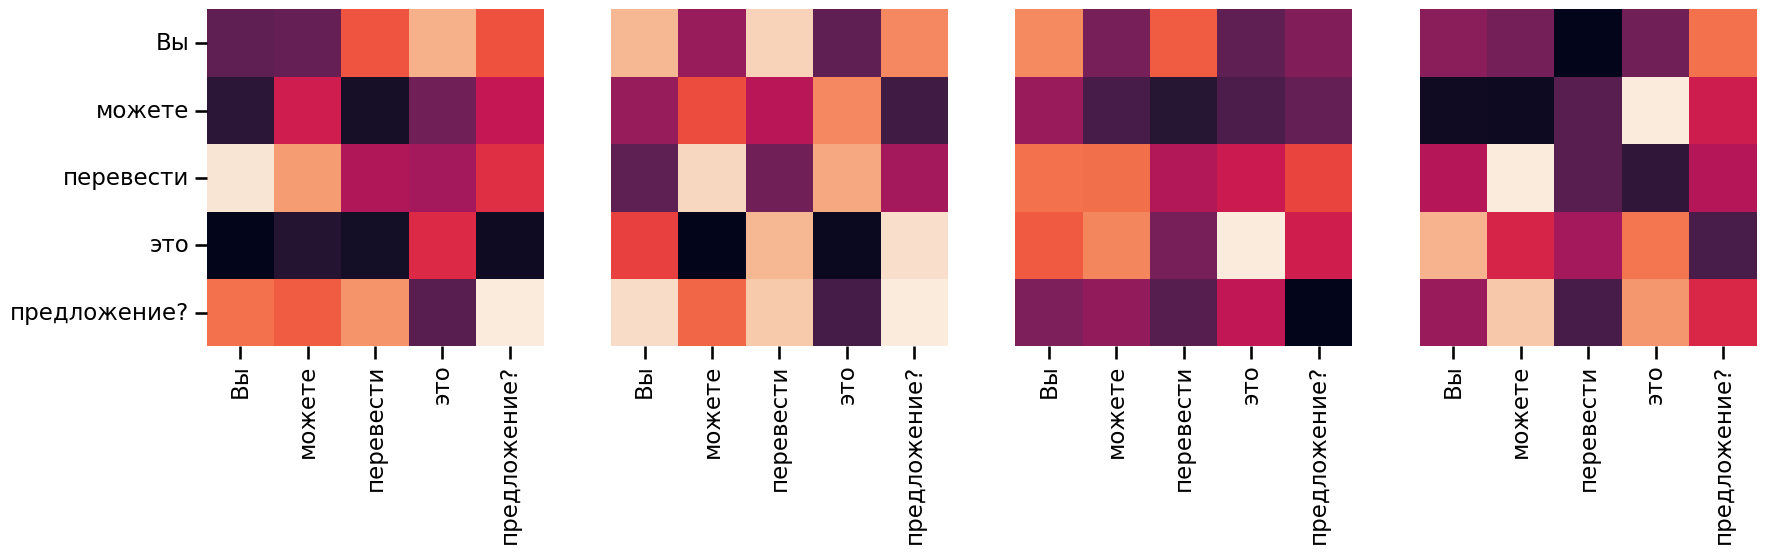

Decoder Self Layer 1


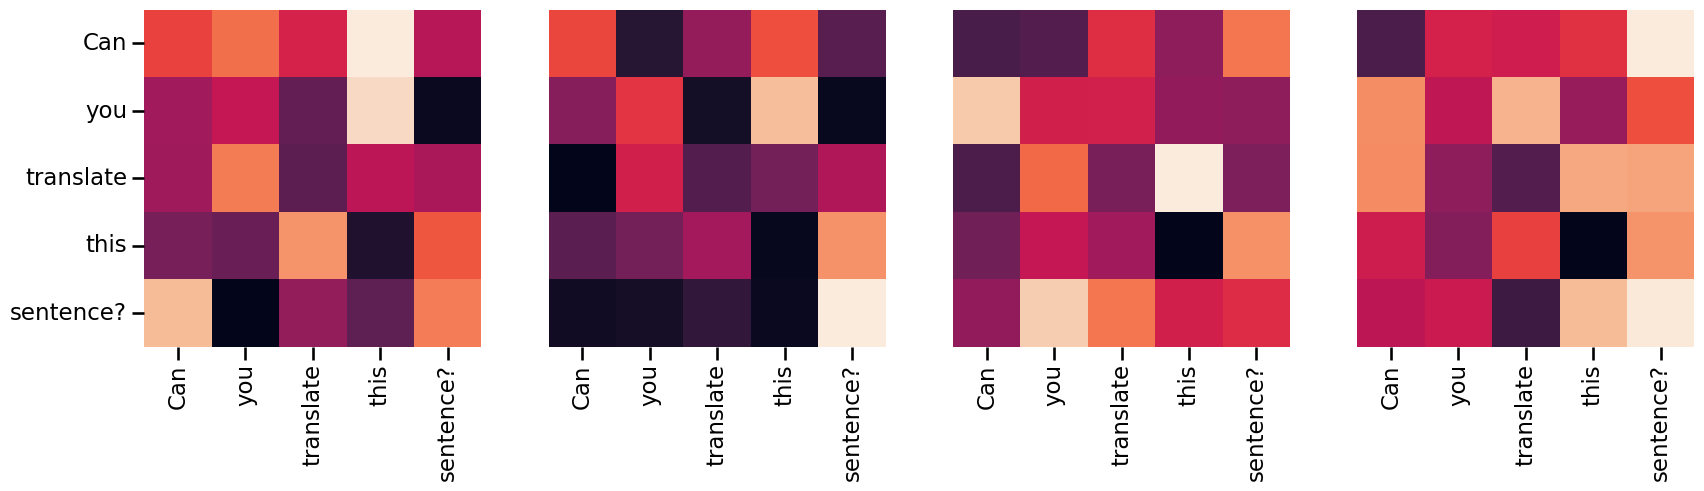

Decoder Src Layer 1


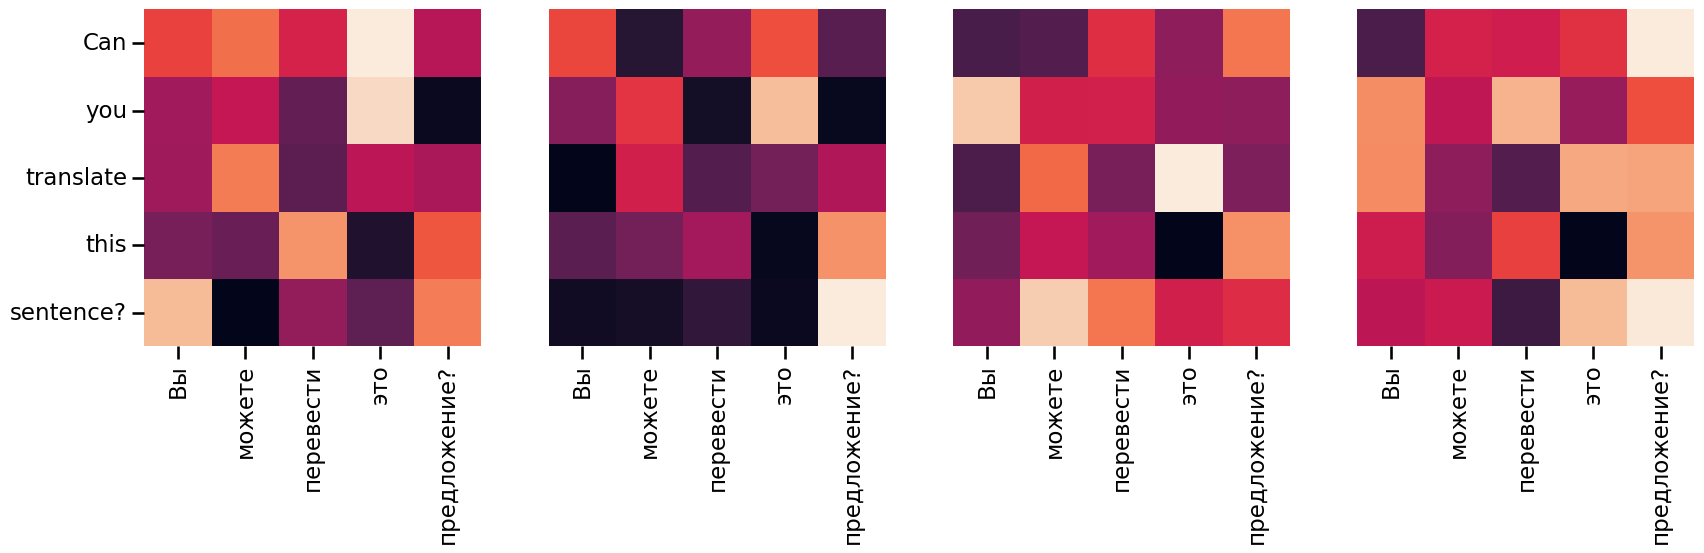

In [ ]:
import seaborn

seaborn.set_context(context="talk")

src_sent, tgt_sent = sent.split(), trans.split()


def draw(data, x, y, ax):
    seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, cbar=False, ax=ax)


layer = 0
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
print("Encoder Layer", layer + 1)
for h in range(4):
    draw(
        model.encoder.layers[layer]
        .self_attn.linears[h]
        .weight.data[: len(src_sent), : len(src_sent)]
        .cpu(),
        src_sent,
        src_sent if h == 0 else [],
        ax=axs[h],
    )
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
print("Decoder Self Layer", layer + 1)
for h in range(4):
    draw(
        model.decoder.layers[layer]
        .self_attn.linears[h]
        .weight.data[: len(tgt_sent), : len(tgt_sent)]
        .cpu(),
        tgt_sent,
        tgt_sent if h == 0 else [],
        ax=axs[h],
    )
plt.show()
print("Decoder Src Layer", layer + 1)
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for h in range(4):
    draw(
        model.decoder.layers[layer]
        .self_attn.linears[h]
        .weight.data[: len(tgt_sent), : len(src_sent)]
        .cpu(),
        src_sent,
        tgt_sent if h == 0 else [],
        ax=axs[h],
    )
plt.show()

# Развитие архитектуры Трансформер

Архитектура классического Трансформера состоит из кодировщика и декодировщика. Эти блоки можно использовать по отдельности:
- Модели на основе декодировщика применяются для генерации текста и используют маскированное внимание (Generative Pre-trained Transformers, GPT)
- Модели на основе кодировщика применяются для других задач: классификации одного или пары предложений, теггирования последовательности, поиска ответа на вопрос (Bidirectional Encoder Representations from Transformers, BERT)

Архитектуру этих моделей мы подробно рассмотрим на следующих двух занятиях.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/transformer_models.PNG" width="800"></center>

<center><em>Source: <a href="https://medium.com/@reyhaneh.esmailbeigi/bert-gpt-and-bart-a-short-comparison-5d6a57175fca">BERT, GPT and BART: a short comparison</a></em></center>

Классический трансформер на основе кодировщика и декодировщика используется для задачи машинного перевода — преобразования одной последовательности в другую, при эхтом длина входной и выходной последовательностей может не совпадать (sequence-to-sequence).

Помимо машинного перевода, к задачам sequence-to-sequence относятся следующие:
- Суммаризация
- Перефразирование
- Перенос стиля текста
- Генерация ответов в диалоге
- Исправление опечаток
- Преобразование данных в текст (структурированных данных, изображений, записей речи).

В этом разделе рассмотрим модели на основе кодировщика и декодировщика: BART и T5.

## BART

BART — sequence-to-sequence Трансформер, который предобучается реконструкции испорченного зашумлённого текста. На входе у модели каким-то образом испорченный текст, а на выходе ей надо сгенерировать его оригинальную версию.

[[paper] 🎓 Lewis M. et al. (2019). BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension](https://arxiv.org/abs/1910.13461)

Способы зашумления текста:

- Маскировка токенов
- Удаление токенов
- Маскировка нескольких подряд идущих токенов одним спецтокеном [MASK]
- Перемешивание предложений
- "Вращение" документа относительно случайного токена
  - делаем этот токен началом документа, а всё, что было до него, переносим в конец

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/bart.png" width="500"></center>

<center><em>Source: <a href="https://arxiv.org/abs/1910.13461">BART: Denoising Sequence-to-Sequence Pre-training</a></em></center>

Кроме английской версии BART была обучена ещё и многоязычная версия этой модели, mBART. При предобучении использовались одноязычные части корпуса, то есть никаких переводов модель не видела. Русский язык — второй по степени представленности после английского. Это позволяет использовать эту модель и для русского языка тоже.

[[paper] 🎓 Liu Y. et al. (2020). Multilingual Denoising Pre-training for Neural Machine Translation](https://arxiv.org/abs/2001.08210)

## T5

T5 — ещё одна sequence-to-sequence модель. Её название расшифровывается  как text-to-text transfer transformer.

[[paper] 🎓 Raffel C. (2019). Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683)

Text-to-text означает, что модель T5 принимает на вход тексты и "читает" их кодировщиком, а потом "пишет" декодировщиком новые тексты и отдаёт на выход. Слово transfer говорит о цели этой модели: она предобучалась восстанавливать пропущенные фрагменты текста. При обучении промежутки исходного текста скрываются, и задача модели — их сгенерировать. В отличие от BART, где текст генерируется целиком, T5 нужно сгенерировать только сами скрытые промежутки.

<center><img src="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/t5.png" width="400"></center>

<center><em>Source: <a href="https://arxiv.org/abs/1910.10683">Text-to-Text Transformer</a></em></center>

Аналогично mBART, кроме английской версии T5 была обучена ещё и многоязычная версия этой модели, mT5.

[[paper] 🎓 Xue L. (2020). mT5: A massively multilingual pre-trained text-to-text transformer](https://arxiv.org/abs/2010.11934)

# Токенизация

Один из ключевых этапов в обработке текста — **токенизация**. На этом этапе происходит разделение текста на отдельные единицы — предложения и слова. Затем создается словарь, в который заносятся уникальные лексемы, встретившиеся в корпусе или тексте. На этих этапах можно столкнуться с несколькими проблемами.

**Проблема 1. Размер словаря**

Самый простой способ токенизации — назначить каждому уникальному слову своё число. Но есть проблема: слов и их форм миллионы, и поэтому словарь таких слов получится чересчур большим, а это будет затруднять обучение модели.

Можно разбивать текст не на слова, а на отдельные буквы (char-level tokenization), тогда в словаре будет всего несколько десятков токенов, НО в таком случае уже сам текст после токенизации будет слишком длинным, а это тоже затрудняет обучение.

**Проблема 2. Богатая морфология**

"Нейросеть", "нейросетью", "нейросетями" являются разными словами, но имеют одинаковый смысл. Эту проблему классически всегда решал этап **стемминга** (удаление суффикса и окончания) или **лемматизации** (приведение слова к канонической форме).

**Проблема 3. Сложные слова**

Но все проблемы эти этапы не решают. В германских языках (в немецком, шведском, датском) очень продуктивно образовываются новые сложные слова. Значения таких слов выводятся из значения их элементов. Их можно создавать бесконечно долго, и большинство из них не зафиксировано в «бумажном» словаре.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/swedish_word_example.png" width="600"></center>

<center><em>Пример шведского названия гаечного ключа для колеса мотоцикла</a></em></center>

<center><em>Source: <a href="https://sysblok.ru/nlp/7250/">Как работает алгоритм токенизации текстов для нейросетей</a></em></center>

При работе с этими языками сложность также возникает на этапе составления словаря. При составлении словаря модели ориентируются на частотность (например, сохраняем слово, если оно встретилось чаще пяти раз), поэтому не будут запоминать такое длинное и сложное слово.

**Проблема 4: Границы слова**

Для нас, привыкших к языкам европейского типа, слово — это набор букв между пробелами и знаками препинания. Но в английском языке многие сложные слова пишутся раздельно, а в японском, наоборот, между словами вообще нет пробелов. Поэтому универсальный токенизатор создать было нелегко.

## BPE-токенизация

Byte Pair Encoding (BPE) — алгоритм для токенизации на подслова. Он позволяет эксплицитно задавать размер словаря. Этот тип токенизации используется во многих моделях трансформеров, включая GPT, GPT-2, RoBERTa, BART.

Есть два полярных варианта: токенизация на слова и токенизация на символы. Будем последовательно двигаться от посимвольной токенизации к пословной. Остановимся в тот момент, когда будет достигнут нужный размер словаря.

Для каждого слова подсчитывается частота встречаемости в корпусе. Вначале все слова в корпусе разбиваются на символы, к последним символам прибавляется символ конца слова.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/BPE1.png" width="700"></center>

<center><em>Source: <a href="https://wikidocs.net/166315">Tokenizers: How machines read </a></em></center>

Теперь наш словарь состоит из символов. Для каждого подсчитана частота встречаемости в корпусе. Размер словаря равен 27.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/BPE2.png" width="700"></center>

<center><em>Source: <a href="https://wikidocs.net/166315">Tokenizers: How machines read </a></em></center>

На каждом шаге мы хотим объединять символы, которые чаще всего встречаются вместе.

Посчитаем частоту биграмм. В нашем корпусе самой частотной оказывается биграмма *de*.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/BPE3.png" width="700"></center>

<center><em>Source: <a href="https://wikidocs.net/166315">Tokenizers: How machines read </a></em></center>

Теперь в словаре появилась одна биграмма. Размер словаря равен 28. При этом частота символов *d* и *e* понизилась, они стали более редкими.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/BPE4.png" width="700"></center>

<center><em>Source: <a href="https://wikidocs.net/166315">Tokenizers: How machines read </a></em></center>

Аналогичное действие повторяется много раз. На каждом шаге в словарь добавляется новый токен (n-грамма).

В конце работы алгоритма словарь будет включать наиболее частотные слова, а более редкие будут представлены подсловами.

Этот же способ помогает решить **проблему** **OOV (out of vocabulary)**. В обучающей выборке может не быть слова *Unfriendly*, но поскольку **Unfriendly** = **Un** + **friend** + **ly**, мы можем рассчитывать, что сеть будет правильно обрабатывать / генерировать и слово целиком.

<center><img src ="https://edunet.kea.su/repo/EduNet_NLP-web_dependencies/L05/token_unfriendly.png" width="600"></center>

<center><em>Source: <a href="https://www.thoughtvector.io/blog/subword-tokenization/">Subword Tokenization — Handling Misspellings and Multilingual Data</a></em></center>

<font size = 6> Заключение </font>

- Была рассмотрена архитектура Трансформер, позволяющая учитывать контекст предложения с помощью механизма внимания.
- Воспроизведена архитектура классического Трансформера.
- Модель обучена на искусственных данных (копирование последовательности цифр) и на реальных данных Tatoeba для перевода с русского на английский.
- Рассмотрено применение моделей-трансформеров для других задач.
- Описан метод токенизации Byte-Pair Encoding, который используется в трансформерных моделях.